In [7]:
import qiskit, qiskit_aer
import random
import qiskit.utils
import qiskit.visualization
qr = qiskit.QuantumRegister(3)
cr = qiskit.ClassicalRegister(3)
qc = qiskit.QuantumCircuit(qr,cr)
qr2 = qiskit.QuantumRegister(6)
cr2 = qiskit.ClassicalRegister(6)
qc2 = qiskit.QuantumCircuit(qr2,cr2)
backend = qiskit_aer.AerSimulator()

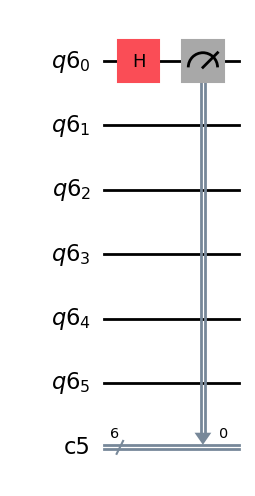

In [8]:
qc2.h(0)

qc2.measure(0,0)

qc2.draw(output='mpl')

In [10]:
new_circuit2 = qiskit.transpile(qc2,backend)
job = backend.run(new_circuit2, shots=1024)
result = job.result()
counts=result.get_counts()
qiskit.visualization.plot_histogram(counts)
print(counts)

{'000001': 513, '000000': 511}
